In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from simulations_creation import parameters

THEME_COLORS = ["chocolate", "hotpink", "royalblue", "lime", "red", "olive", "orange", "yellow"]

def define_tscv_size_multiple(raw_multiple):
    diffs = {multiple: abs(multiple - raw_multiple) for multiple in parameters["tscv_size_multiple"]}
    return min(diffs, key=diffs.get)

def clean_for_latex(df):
    def escape_latex(s):
        return (s.replace('%', '\\%')
                .replace('&', '\\&')
                .replace('#', '\\#')
                .replace('_', '\\_')
                .replace('{', '\\{')
                .replace('}', '\\}')
                .replace('~', '\\textasciitilde ')
                .replace('^', '\\textasciicircum ')
                .replace('$', '\\$')
                .replace('\n', ' \\ ')
            )
    for col in df.columns:
        df[col] = df[col].astype(str).apply(escape_latex)

    return df

In [2]:
yearly_performance_metrics = (
    pd.read_csv("output/simulations_yearly_performance_metrics.csv")
    .assign(tscv_size_multiple=lambda df: (df.tscv_size / df.training_window).map(lambda x: define_tscv_size_multiple((x))))
    .assign(training_window_and_tscv_size_multiple=(
        lambda df: df.training_window.map(lambda x: f"{x:03}") + "-" + df.tscv_size_multiple.map(lambda x: f"{x:.0%}")
    ))
    .assign(training_window=lambda df: df.training_window.map(lambda x: f"{x:03}"))
    .assign(testing_window=lambda df: df.testing_window.map(lambda x: f"{x:03}"))
    .assign(tscv_size_multiple=lambda df: df.tscv_size_multiple.map(lambda x: f"{x:.0%}").map(lambda x: "0" + x if len(x) == 3 else x))
)
yearly_performance_metrics

,id,n_assets,training_window,testing_window,n_tscv,tscv_size,tscv_metric,testing_metric,n_days,year,count,sharpe,annualized_mean,annualized_std,tscv_size_multiple,training_window_and_tscv_size_multiple
0,0,5,063,005,1,32,sharpe,sharpe,12600,2000,252,0.708825,0.130533,0.184154,050%,063-50%
1,0,5,063,005,1,32,sharpe,sharpe,12600,2001,248,-0.776331,-0.134360,0.173070,050%,063-50%
2,0,5,063,005,1,32,sharpe,sharpe,12600,2002,252,-0.869446,-0.195789,0.225188,050%,063-50%
3,0,5,063,005,1,32,sharpe,sharpe,12600,2003,252,1.550130,0.227400,0.146697,050%,063-50%
4,0,5,063,005,1,32,sharpe,sharpe,12600,2004,252,0.440489,0.050128,0.113801,050%,063-50%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123195,5599,30,504,252,8,756,sharpe,sharpe,12600,2017,251,2.606346,0.202622,0.077742,150%,504-150%
123196,5599,30,504,252,8,756,sharpe,sharpe,12600,2018,251,-0.737223,-0.118854,0.161219,150%,504-150%
123197,5599,30,504,252,8,756,sharpe,sharpe,12600,2019,252,1.690824,0.223087,0.131940,150%,504-150%
123198,5599,30,504,252,8,756,sharpe,sharpe,12600,2020,253,0.669976,0.245802,0.366882,150%,504-150%


In [34]:
def plot_yearly_performance_by_metric(metric_opt, xlabel, title_text, img_name, xlabel_rotation=0):
    yearly_performance_avg_metric_opt = (
        yearly_performance_metrics
        .groupby(["year", metric_opt], as_index=False)
        .agg({"sharpe": ['mean', 'std']})
    )
    yearly_performance_avg_metric_opt.columns = ['year', metric_opt, 'sharpe_mean', 'sharpe_std']
    unique_years = len(yearly_performance_avg_metric_opt['year'].unique())
    n_cols = 3
    n_rows = (unique_years + n_cols) // n_cols
    fig = plt.figure(figsize=(16, 3 * n_rows))
    axes = [plt.subplot2grid((n_rows, n_cols), (i // n_cols, i % n_cols), fig=fig) for i in range(n_rows * n_cols - 2)]
    axes.append(plt.subplot2grid((n_rows, n_cols), (n_rows - 1, n_cols - 2), colspan=2, fig=fig))
    for index, year_opt in enumerate(yearly_performance_avg_metric_opt['year'].unique()):
        ax = axes[index]
        avg_metric_year_opt = yearly_performance_avg_metric_opt[yearly_performance_avg_metric_opt['year'] == year_opt]
        ax.errorbar(
            avg_metric_year_opt[metric_opt], avg_metric_year_opt["sharpe_mean"],
            yerr=avg_metric_year_opt["sharpe_std"], 
            linestyle='-', marker='o', color="black", label=f'Avg Sharpe {year_opt}', ecolor='black', capsize=3,
        )
        ax.fill_between(
            avg_metric_year_opt[metric_opt],
            avg_metric_year_opt["sharpe_mean"] - avg_metric_year_opt["sharpe_std"],
            avg_metric_year_opt["sharpe_mean"] + avg_metric_year_opt["sharpe_std"],
            color='gray', alpha=0.1,
            label="+/- STD"
        )
        ax.set_title(f'Year {year_opt}')
        ax.set_ylabel('Sharpe')
        ax.set_xlabel('Nº TSCV')
        ax.set_xticks(avg_metric_year_opt[metric_opt])
        ax.set_xticklabels(avg_metric_year_opt[metric_opt], rotation=xlabel_rotation)
        ax.legend()
    ax_big = axes[-1]
    yearly_performance_overall_avg_metric_opt = yearly_performance_avg_metric_opt.groupby(metric_opt).agg({'sharpe_mean': 'mean', 'sharpe_std': 'mean'})
    ax_big.errorbar(
        yearly_performance_overall_avg_metric_opt.index, yearly_performance_overall_avg_metric_opt["sharpe_mean"],
        yerr=yearly_performance_overall_avg_metric_opt["sharpe_std"],
        linestyle='-', marker='o', color="black", label='Overall Avg Sharpe', ecolor='black', capsize=5
    )
    ax_big.fill_between(
        yearly_performance_overall_avg_metric_opt.index,
        yearly_performance_overall_avg_metric_opt["sharpe_mean"] - yearly_performance_overall_avg_metric_opt["sharpe_std"],
        yearly_performance_overall_avg_metric_opt["sharpe_mean"] + yearly_performance_overall_avg_metric_opt["sharpe_std"],
        color='gray', alpha=0.1,
        label="+/- STD"
    )
    ax_big.set_title("Aggregate Performance")
    ax_big.set_ylabel('Sharpe')
    ax_big.set_xlabel(xlabel)
    ax_big.legend()
    fig.suptitle(f"Annualized Yearly Sharpe by {title_text}")
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.savefig(f'reports/graphics/time_series/{img_name}.png')
    plt.show()

    agg_yearly_performance = (
        pd.concat([
            (
            yearly_performance_overall_avg_metric_opt
                .reset_index()
                .assign(year="Aggregate")
                .loc[:, ["year", metric_opt, "sharpe_mean", "sharpe_std"]]
            ),
            yearly_performance_avg_metric_opt,
        ])
        .assign(result=lambda df: (
            df.sharpe_mean.map(lambda x: f"{x:.2f}") # + "  " + df.sharpe_std.map(lambda x: f"({x:.2f})")
        ))
        .pivot(index="year", columns=metric_opt, values="result")
        .rename_axis(None, axis=1)
        .rename_axis(None, axis=0)
    )
    return agg_yearly_performance

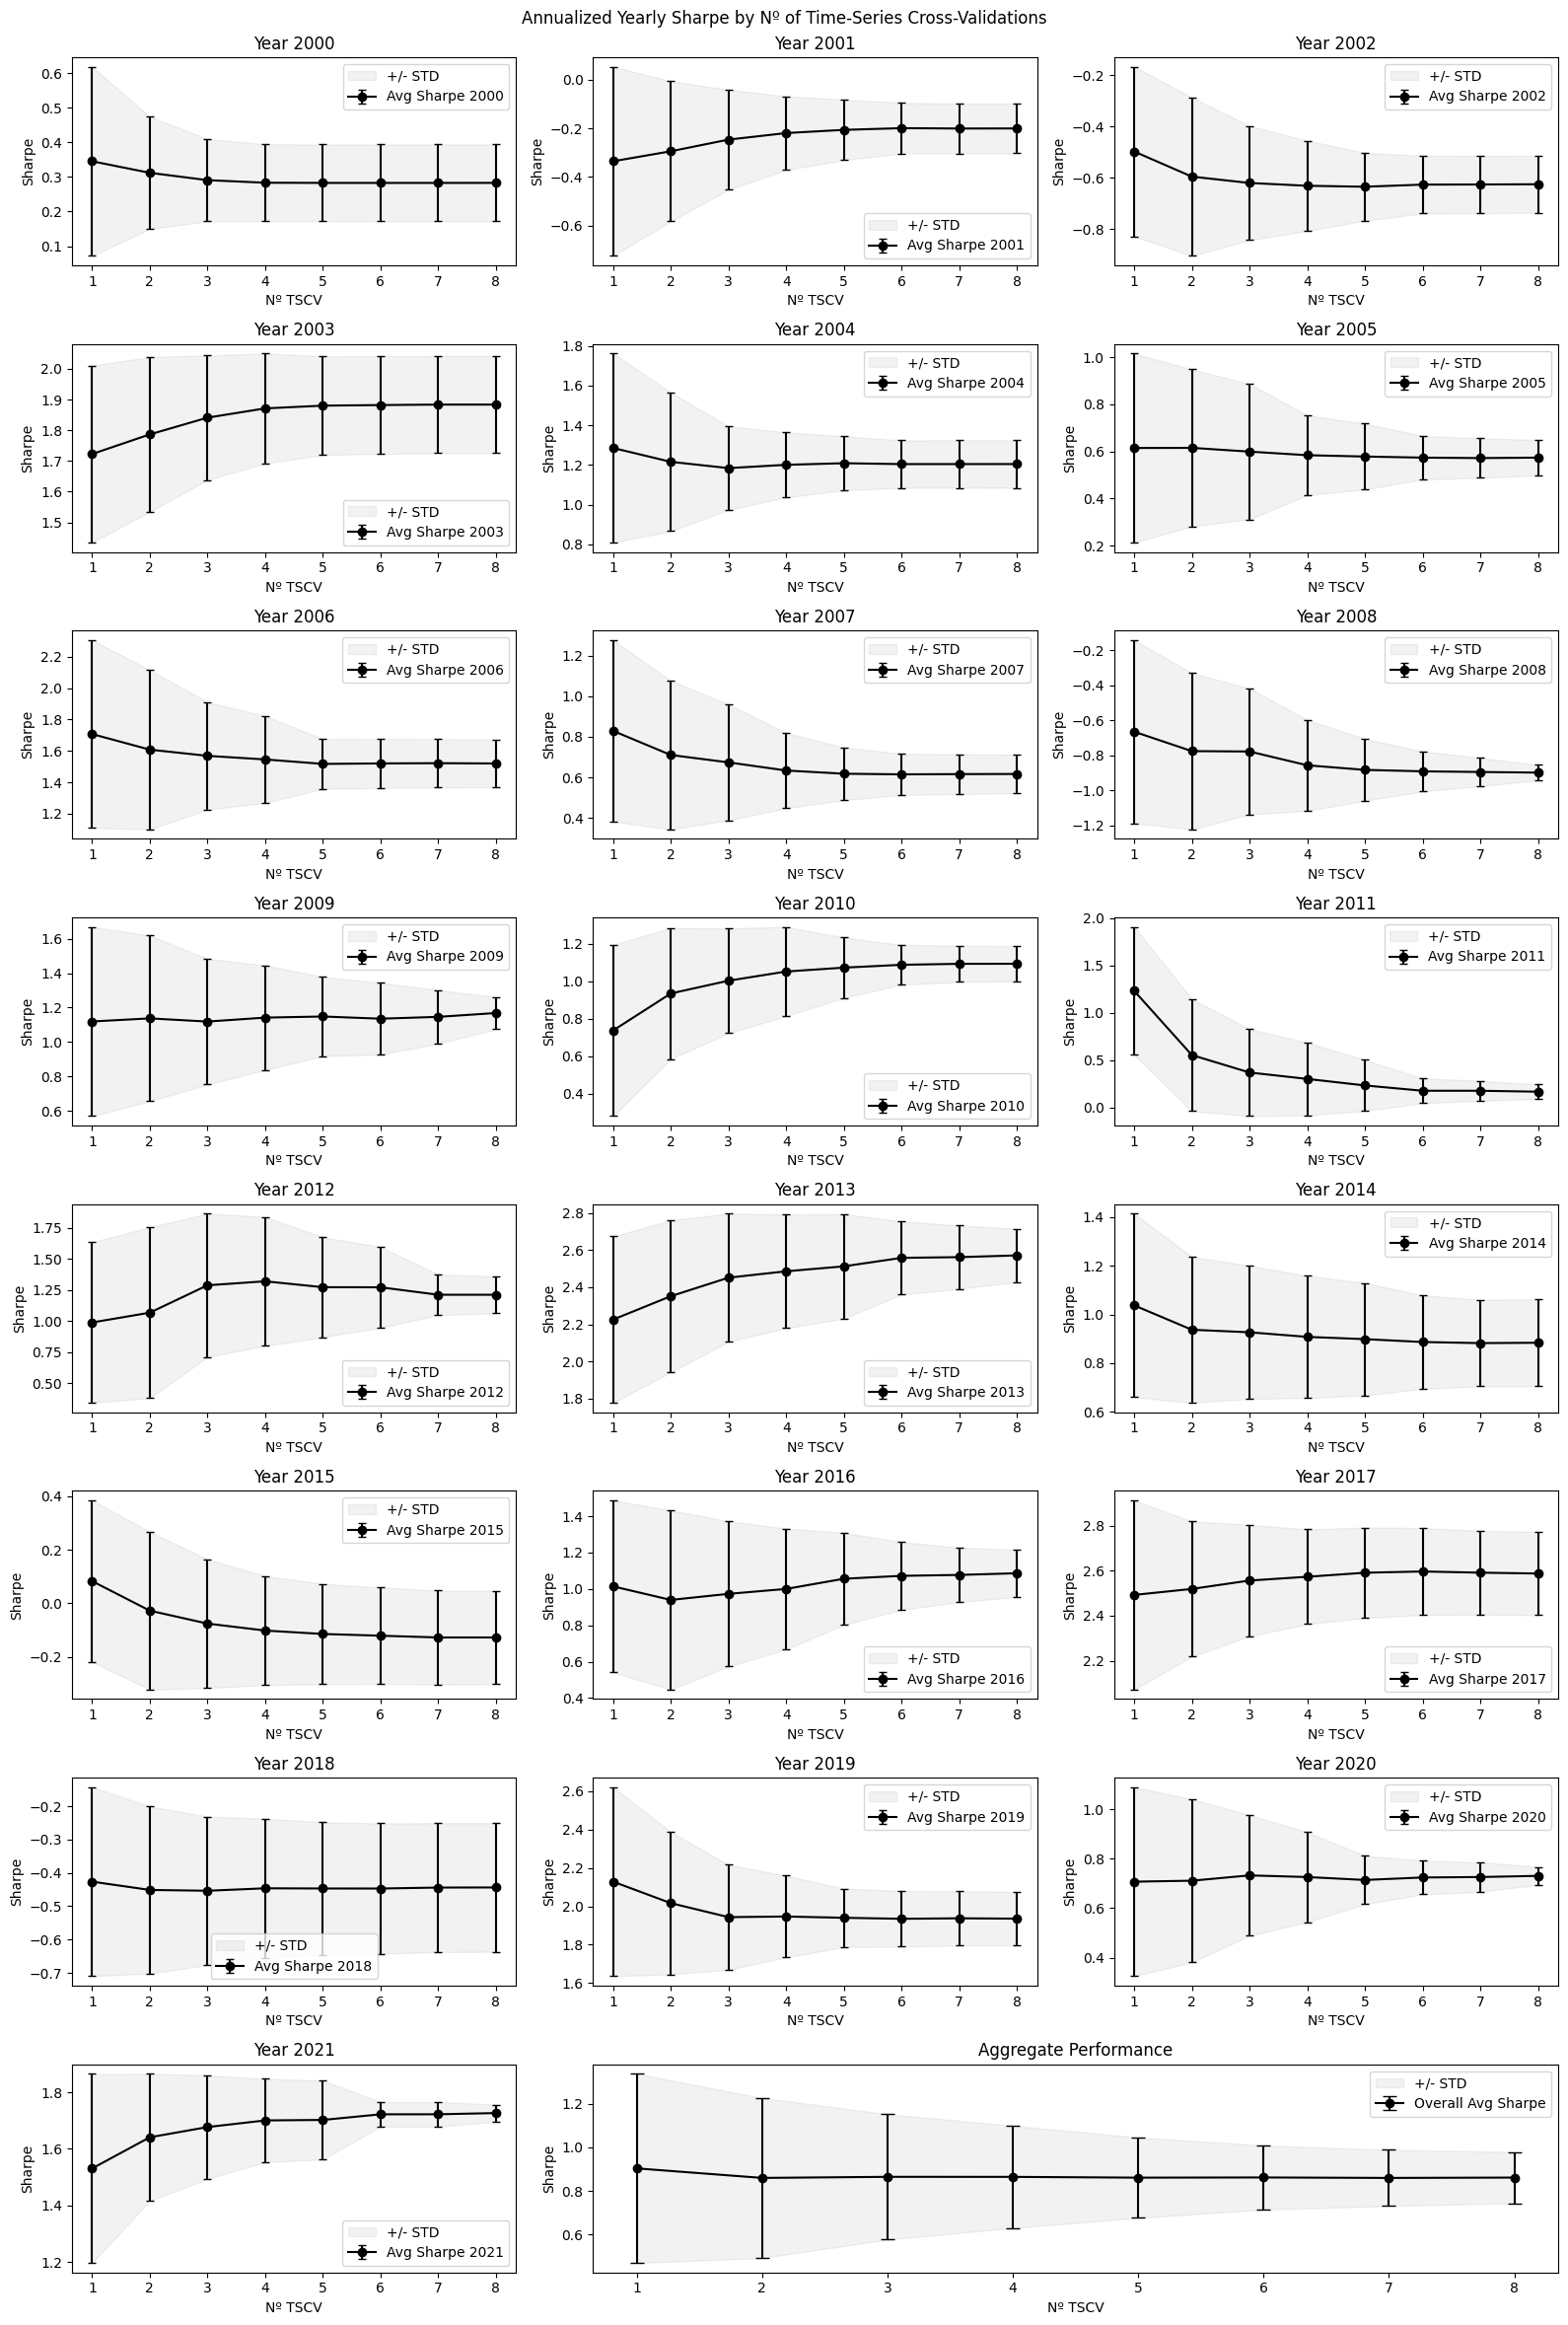

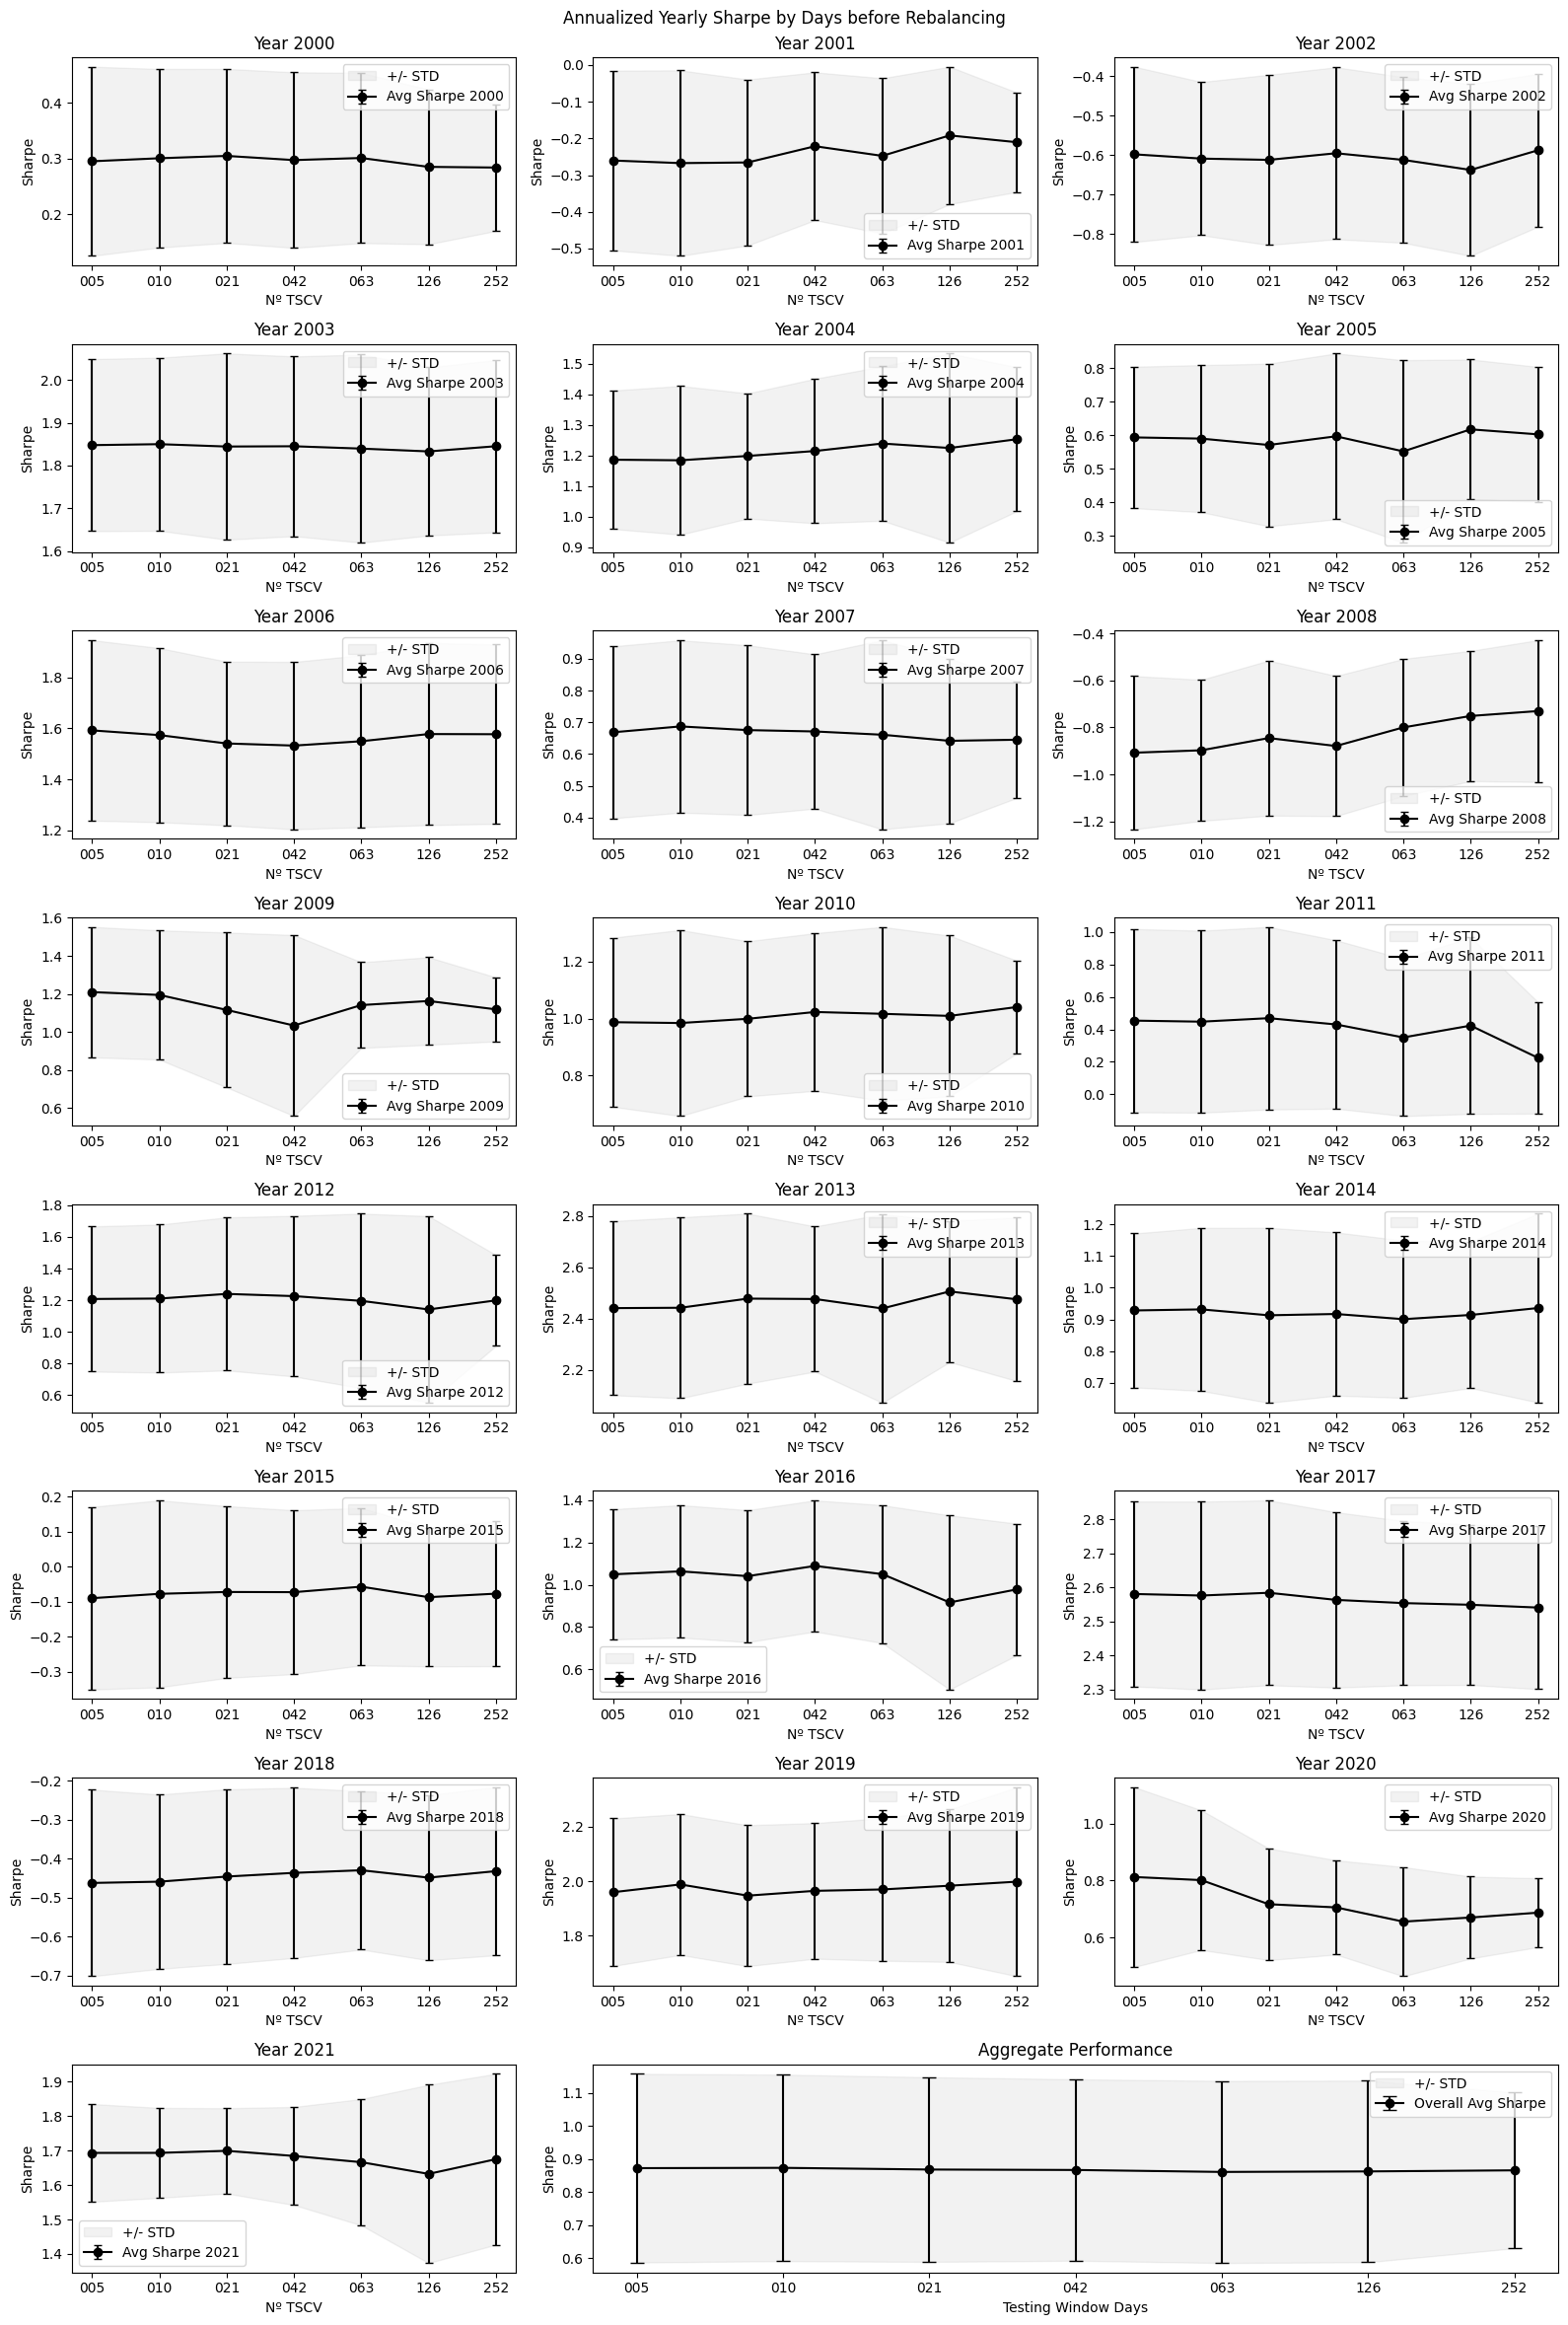

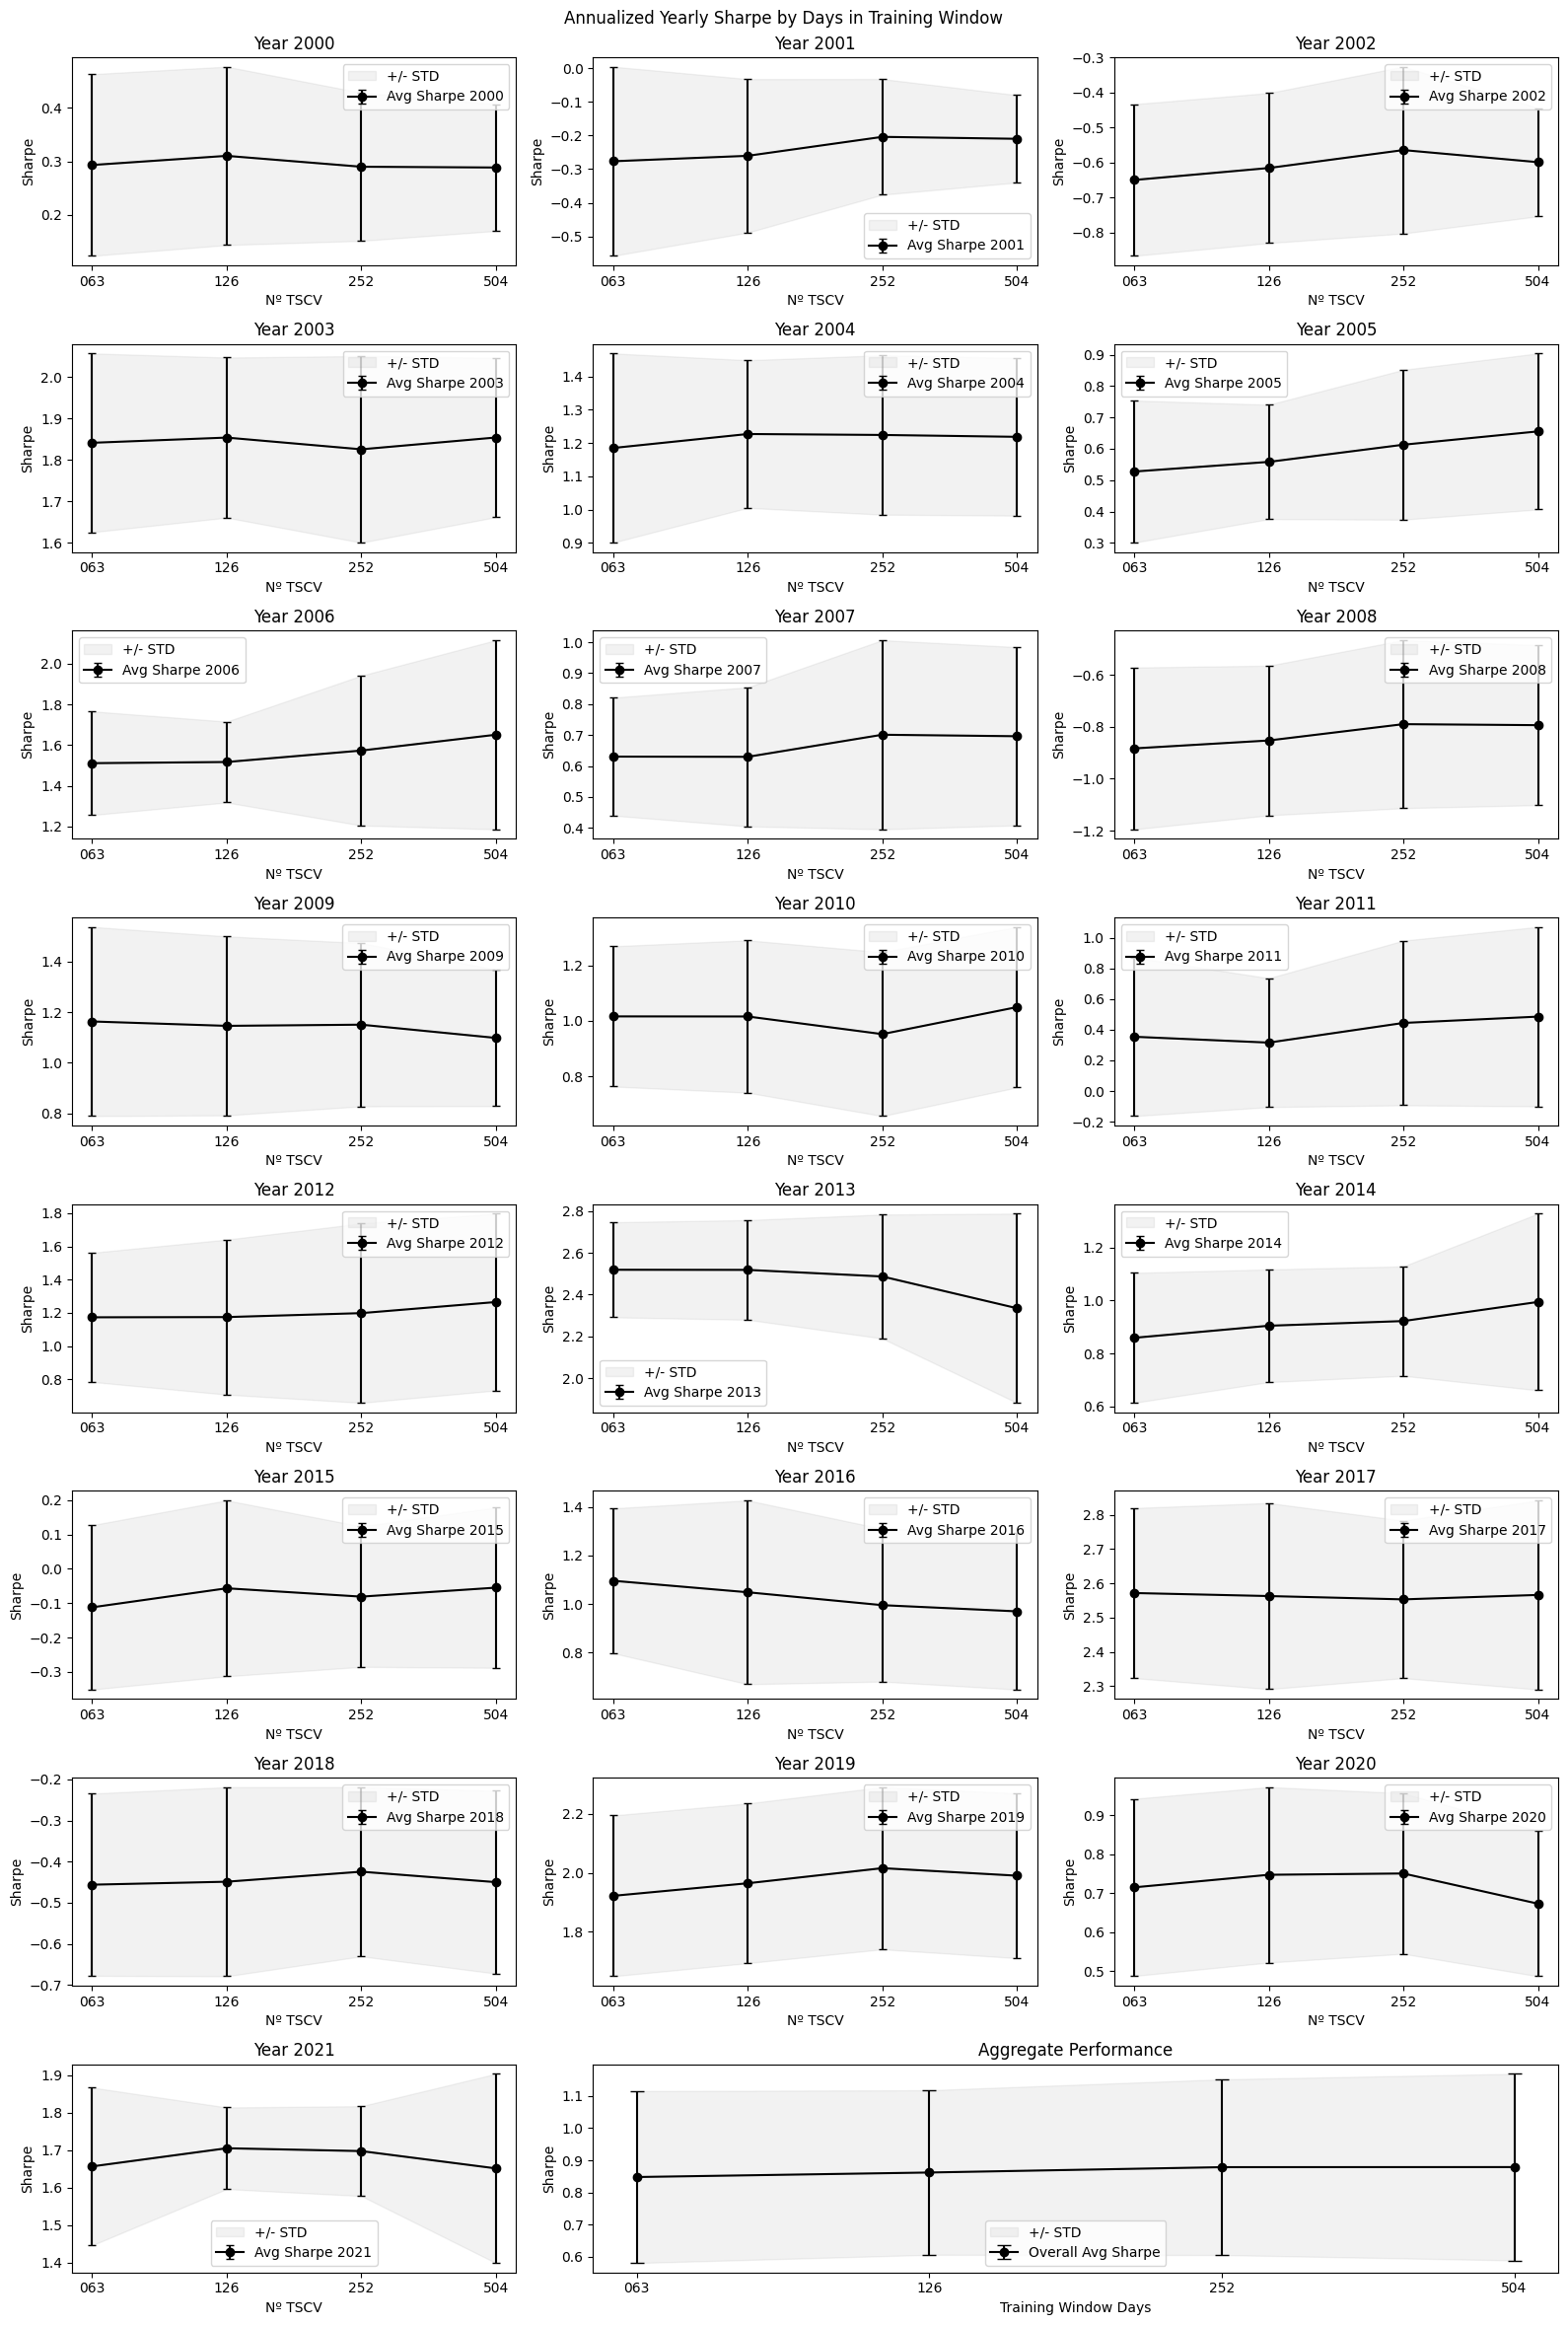

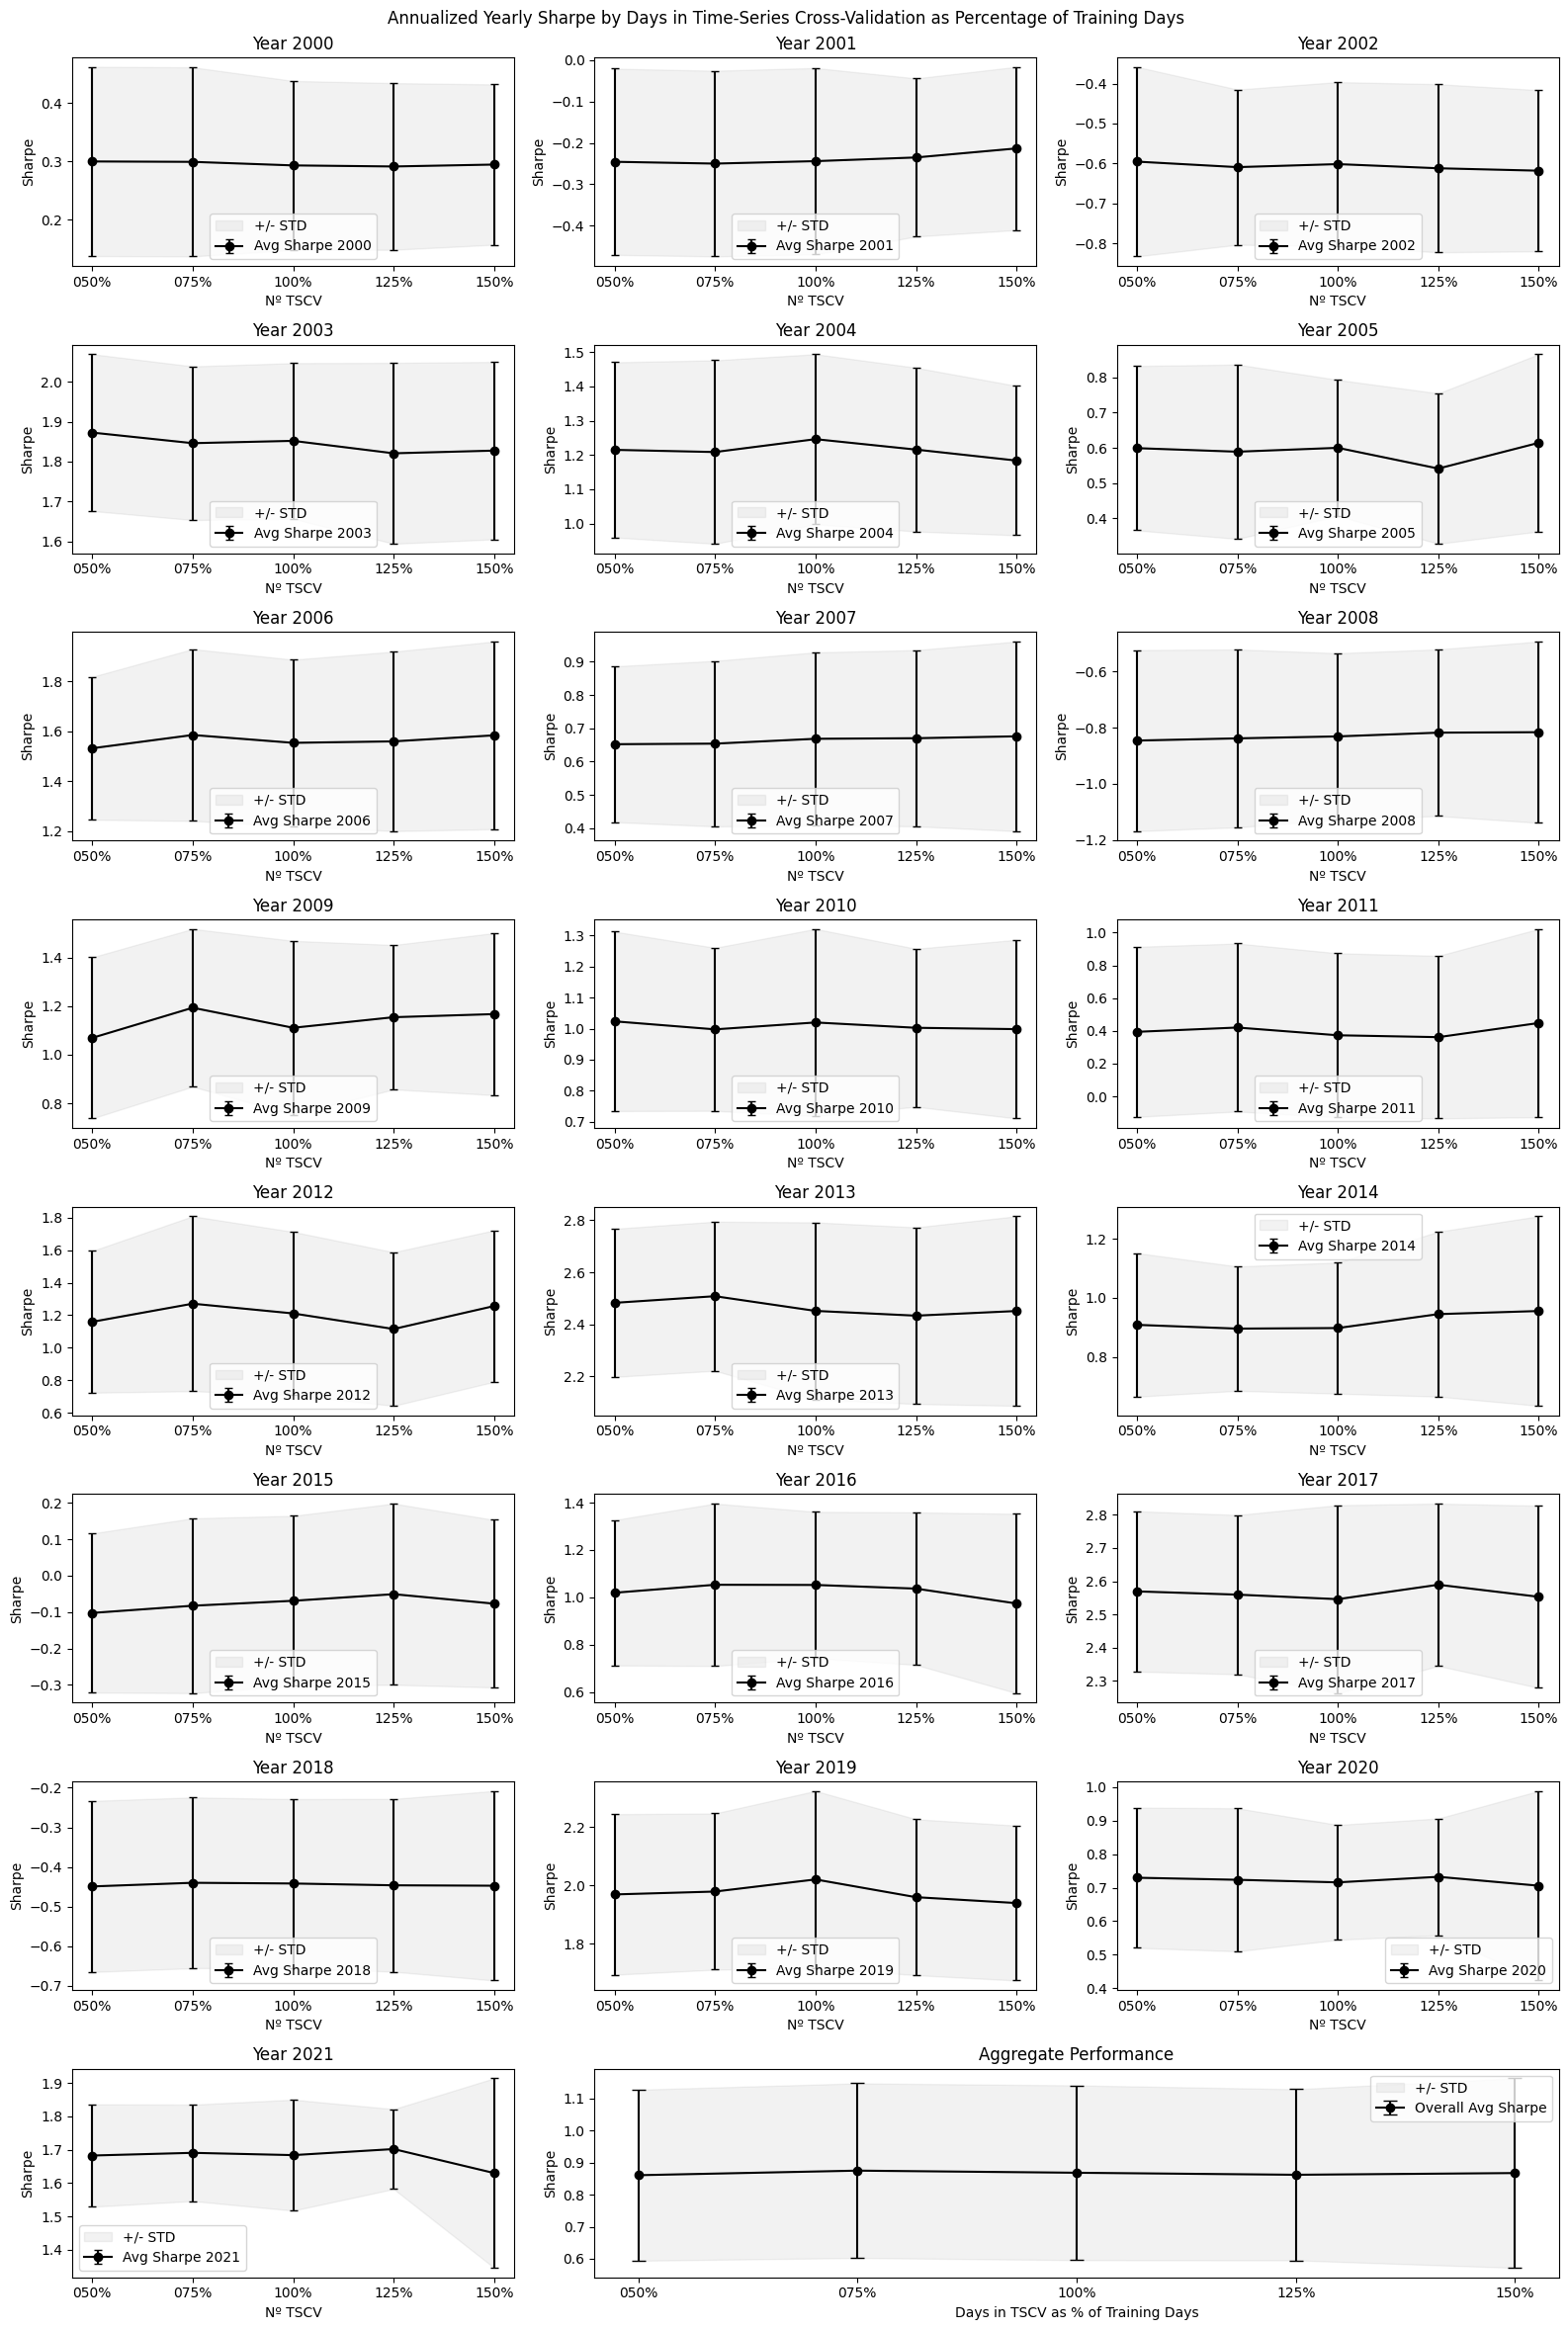

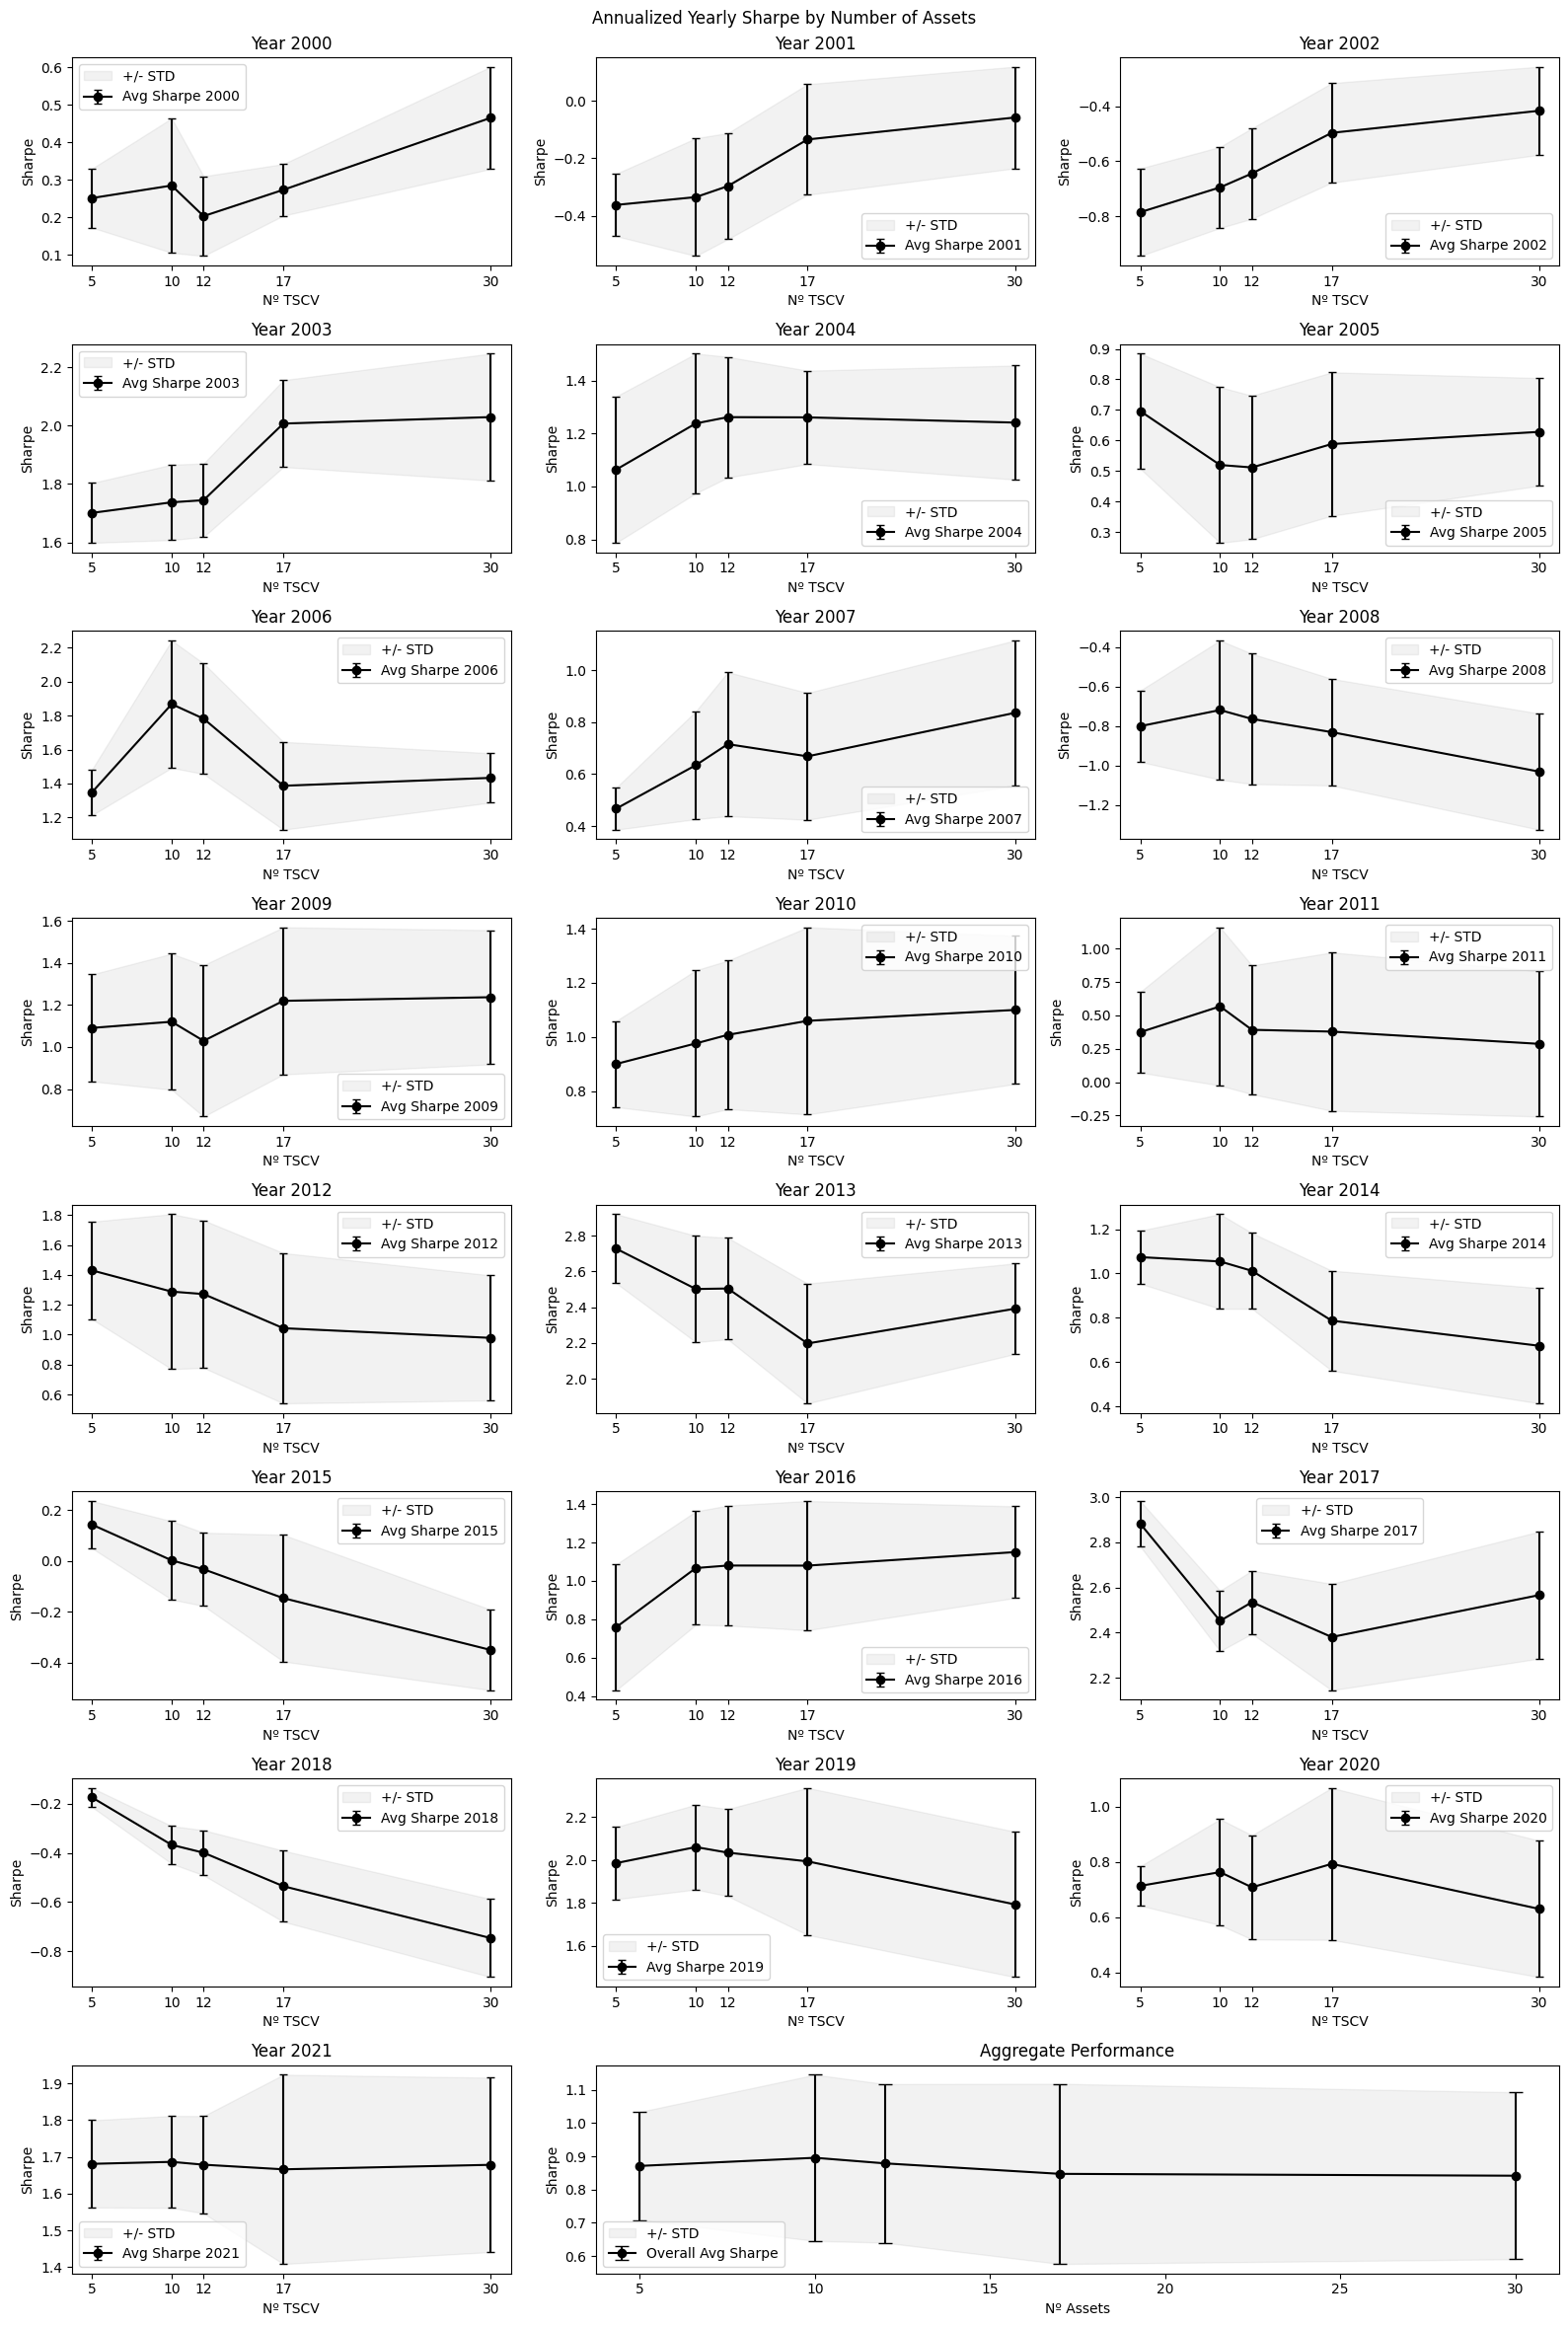

In [35]:
agg_yearly_performance = plot_yearly_performance_by_metric(
    "n_tscv",
    "Nº TSCV",
    "Nº of Time-Series Cross-Validations",
    "n_tscv"
)
clean_for_latex(agg_yearly_performance).to_latex("reports/tables/time_series/n_tscv.tex", escape=True)

agg_yearly_performance = plot_yearly_performance_by_metric(
    "testing_window",
    "Testing Window Days",
    "Days before Rebalancing",
    "testing_window"
)
clean_for_latex(agg_yearly_performance).to_latex("reports/tables/time_series/testing_window.tex", escape=True)

agg_yearly_performance = plot_yearly_performance_by_metric(
    "training_window",
    "Training Window Days",
    "Days in Training Window",
    "training_window"
)
clean_for_latex(agg_yearly_performance).to_latex("reports/tables/time_series/training_window.tex", escape=True)

agg_yearly_performance = plot_yearly_performance_by_metric(
    "tscv_size_multiple",
    "Days in TSCV as % of Training Days",
    "Days in Time-Series Cross-Validations as Percentage of Training Days",
    "tscv_size_multiple"
)
clean_for_latex(agg_yearly_performance).to_latex("reports/tables/time_series/tscv_size_multiple.tex", escape=True)


agg_yearly_performance = plot_yearly_performance_by_metric(
    "n_assets",
    "Nº Assets",
    "Number of Assets",
    "n_assets"
)
clean_for_latex(agg_yearly_performance).to_latex("reports/tables/time_series/n_assets.tex", escape=True)